In [32]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import cv2

# Remove all the warnings
import warnings
warnings.filterwarnings('ignore')

# Set env CUDA_LAUNCH_BLOCKING=1
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Retina display
%config InlineBackend.figure_format = 'retina'

try:
    from einops import rearrange
except ImportError:
    %pip install einops
    from einops import rearrange

In [33]:
if os.path.exists('dog.jpg'):
    print('dog.jpg exists')
else:
    !wget https://segment-anything.com/assets/gallery/AdobeStock_94274587_welsh_corgi_pembroke_CD.jpg -O dog.jpg

dog.jpg exists


In [36]:
img = torchvision.io.read_image("dog.jpg")
print(img.shape)

torch.Size([3, 1365, 2048])


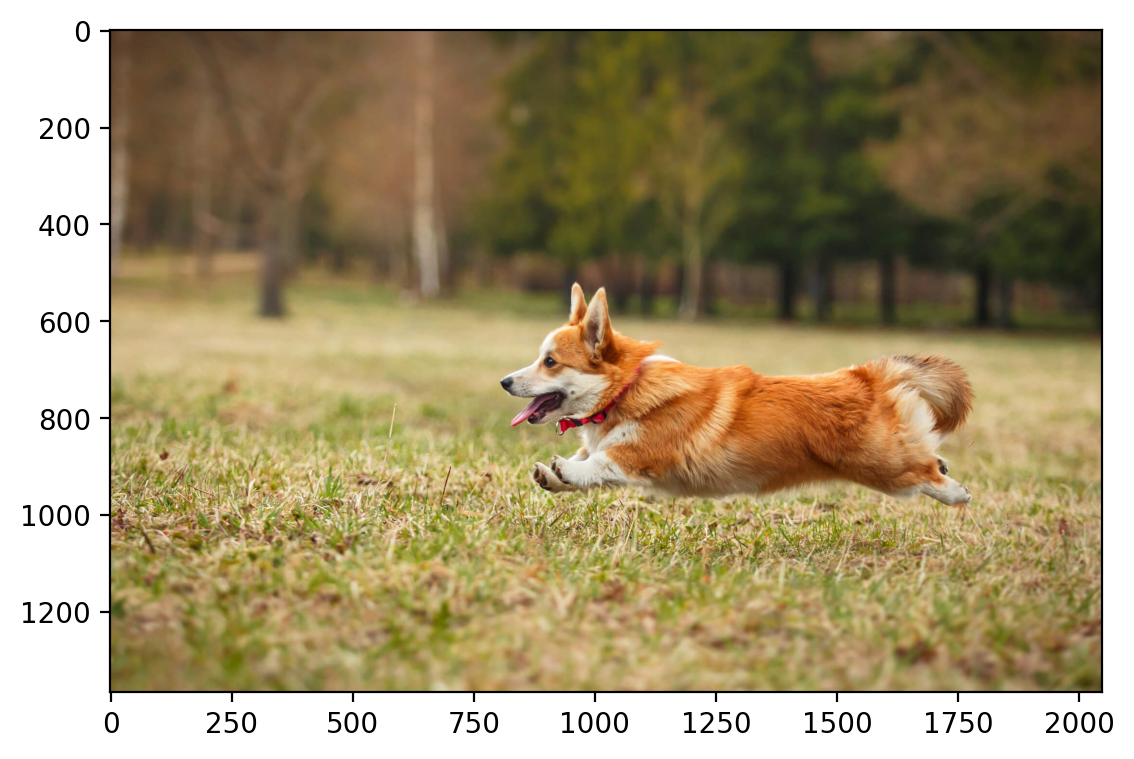

In [37]:
plt.imshow(rearrange(img, 'c h w -> h w c').numpy())

In [38]:
from sklearn import preprocessing

scaler_img = preprocessing.MinMaxScaler().fit(img.reshape(-1, 1))
scaler_img

MinMaxScaler()

In [39]:
img_scaled = scaler_img.transform(img.reshape(-1, 1)).reshape(img.shape)
img_scaled.shape

img_scaled = torch.tensor(img_scaled)

In [40]:
img_scaled = img_scaled.to(device)
img_scaled

tensor([[[0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         [0.3098, 0.3137, 0.3137,  ..., 0.2941, 0.2941, 0.2980],
         ...,
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3765, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3804, 0.3804, 0.3765],
         [0.4745, 0.4745, 0.4784,  ..., 0.3843, 0.3804, 0.3804]],

        [[0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         [0.2039, 0.2078, 0.2078,  ..., 0.2157, 0.2157, 0.2118],
         ...,
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3176, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3216, 0.3216, 0.3176],
         [0.4039, 0.4039, 0.4078,  ..., 0.3255, 0.3216, 0.3216]],

        [[0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.1176],
         [0.1373, 0.1412, 0.1412,  ..., 0.1176, 0.1176, 0.

In [41]:
crop = torchvision.transforms.functional.crop(img_scaled.cpu(), 500, 750, 400, 400)
crop.shape

torch.Size([3, 400, 400])

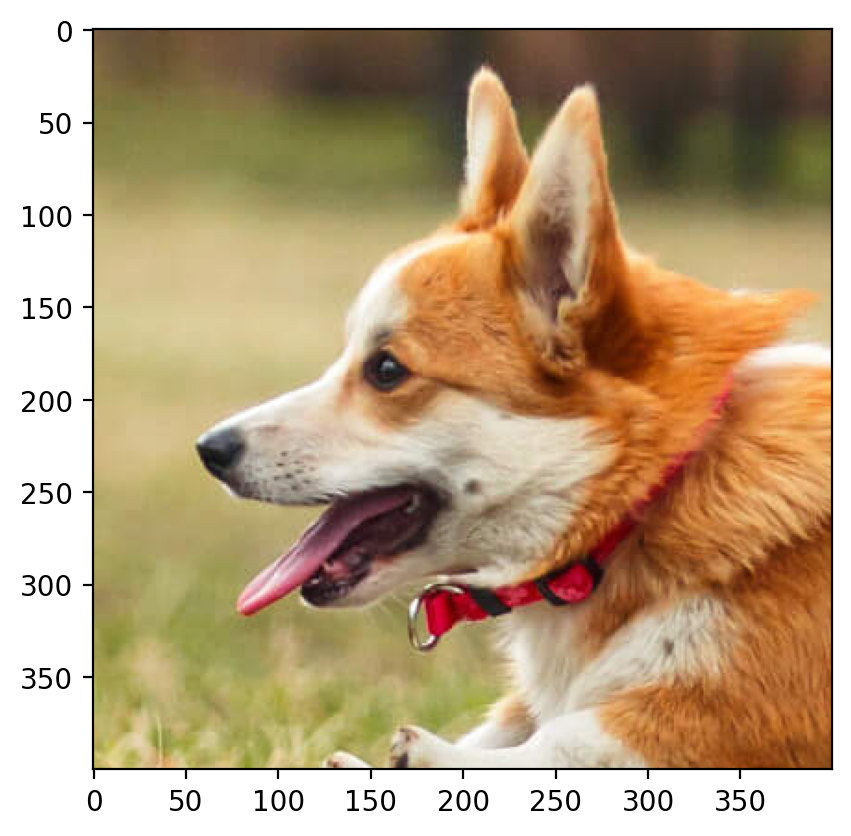

In [42]:
plt.imshow(rearrange(crop, 'c h w -> h w c').cpu().numpy())

Text(0.5, 1.0, 'Resized image 200*200')

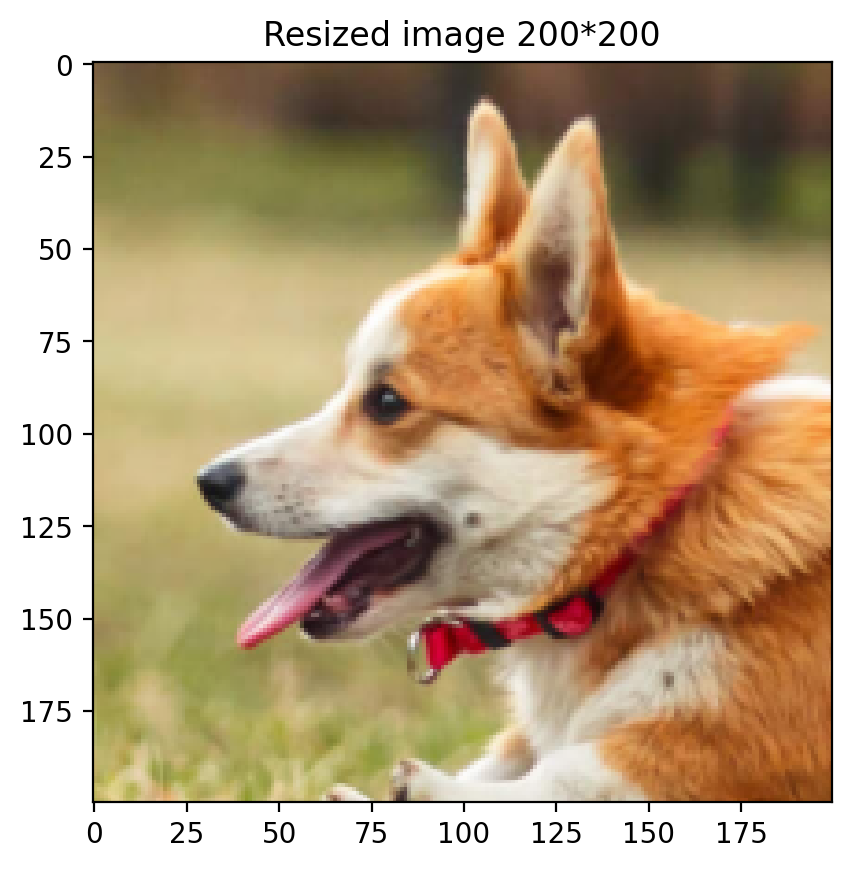

In [43]:
resized_crop = torchvision.transforms.functional.resize(crop,(200,200))
resized_crop.shape
plt.imshow((rearrange(resized_crop,'c h w -> h w c')).cpu().numpy())
resized_crop = resized_crop.to(device)
plt.title("Resized image 200*200")

In [44]:
resized_crop = resized_crop.to(device)

In [45]:
def create_coordinate_map(img, scale=1):
    """
    img: torch.Tensor of shape (num_channels, height, width)

    return: tuple of torch.Tensor of shape (height * width, 2) and torch.Tensor of shape (height * width, num_channels)
    """

    num_channels, height, width = img.shape

    # Create a 2D grid of (x,y) coordinates (h, w)
    # width values change faster than height values
    w_coords = torch.arange(0, width,  1/scale).repeat(int(height*scale), 1)
    h_coords = torch.arange(0, height, 1/scale).repeat(int(width*scale), 1).t()
    w_coords = w_coords.reshape(-1)
    h_coords = h_coords.reshape(-1)

    # Combine the x and y coordinates into a single tensor
    X = torch.stack([h_coords, w_coords], dim=1).float()

    # Move X to GPU if available
    X = X.to(device)

    # Reshape the image to (h * w, num_channels)
    Y = rearrange(img, 'c h w -> (h w) c').float()
    return X, Y

In [46]:
resized_dog_X, resized_dog_Y = create_coordinate_map(resized_crop)

resized_dog_X.shape, resized_dog_Y.shape

(torch.Size([40000, 2]), torch.Size([40000, 3]))

In [47]:
# MinMaxScaler from -1 to 1
scaler_X = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(resized_dog_X.cpu())

# Scale the X coordinates
resized_dog_X_scaled = scaler_X.transform(resized_dog_X.cpu())

# Move the scaled X coordinates to the GPU
resized_dog_X_scaled = torch.tensor(resized_dog_X_scaled).to(device)

# Set to dtype float32
resized_dog_X_scaled = resized_dog_X_scaled.float()

In [48]:
class LinearModel(nn.Module):
    def __init__(self, in_features, out_features):
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x):
        return self.linear(x)

In [49]:
def train(net, lr, X, Y, epochs, verbose=True):
    """
    net: torch.nn.Module
    lr: float
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """

    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    for epoch in range(epochs):
        optimizer.zero_grad()
        outputs = net(X)


        loss = criterion(outputs, Y)
        loss.backward()
        optimizer.step()
        if verbose and epoch % 100 == 0:
            print(f"Epoch {epoch} loss: {loss.item():.6f}")
    return loss.item()

In [50]:
def plot_reconstructed_and_original_image(original_img, net, X, title=""):
    """
    net: torch.nn.Module
    X: torch.Tensor of shape (num_samples, 2)
    Y: torch.Tensor of shape (num_samples, 3)
    """
    num_channels, height, width = original_img.shape
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
        #outputs = outputs.permute(1, 2, 0)
    fig = plt.figure(figsize=(6, 4))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1])

    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    ax0.imshow(outputs.cpu())
    ax0.set_title("Reconstructed Image")


    ax1.imshow(original_img.cpu().permute(1, 2, 0))
    ax1.set_title("Original Image")

    for a in [ax0, ax1]:
        a.axis("off")


    fig.suptitle(title, y=0.9)
    plt.tight_layout()

In [51]:
# create RFF features
def create_rff_features(X, num_features, sigma, random_state = None):
    from sklearn.kernel_approximation import RBFSampler
    rff = RBFSampler(n_components=num_features, gamma=1/(2 * sigma**2),random_state=random_state)
    X = X.cpu().numpy()
    X = rff.fit_transform(X)
    return torch.tensor(X, dtype=torch.float32).to(device)

In [52]:
X_rff = create_rff_features(resized_dog_X_scaled, 10000, 0.008,50)
X_rff.shape

torch.Size([40000, 10000])

In [53]:

net = LinearModel(X_rff.shape[1], 3).to(device)
train(net, lr=0.005, X=X_rff, Y=resized_dog_Y, epochs=1000)

Epoch 0 loss: 0.327642
Epoch 100 loss: 0.051132
Epoch 200 loss: 0.020725
Epoch 300 loss: 0.015788
Epoch 400 loss: 0.013254
Epoch 500 loss: 0.011552
Epoch 600 loss: 0.010329
Epoch 700 loss: 0.009414
Epoch 800 loss: 0.008707
Epoch 900 loss: 0.008147


0.00769889447838068

In [54]:
resized_dog_X1, resized_dog_Y1 = create_coordinate_map(crop, scale=1)

resized_dog_X1.shape, resized_dog_Y1.shape

(torch.Size([160000, 2]), torch.Size([160000, 3]))

In [55]:
# MinMaxScaler from -1 to 1
scaler_X1 = preprocessing.MinMaxScaler(feature_range=(-1, 1)).fit(resized_dog_X1.cpu())

# Scale the X coordinates
resized_dog_X1_scaled = scaler_X1.transform(resized_dog_X1.cpu())

# Move the scaled X coordinates to the GPU
resized_dog_X1_scaled = torch.tensor(resized_dog_X1_scaled).to(device)

# Set to dtype float32
resized_dog_X1_scaled = resized_dog_X1_scaled.float()


In [56]:
X1_rff = create_rff_features(resized_dog_X1_scaled, num_features=10000, sigma=0.008,random_state=50)
print(f"RFF features for 400x400 image: {X1_rff.shape}")  

RFF features for 400x400 image: torch.Size([160000, 10000])


In [57]:

def plot_images(reconst_img, resized_img, original_image, title=""):
    fig = plt.figure(figsize=(18, 6))  
    gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1])

    ax0 = plt.subplot(gs[0])
    ax0.imshow(original_image.cpu().permute(1, 2, 0))
    ax0.set_title('Original Image')

    ax1 = plt.subplot(gs[1])
    ax1.imshow(resized_img.cpu().permute(1, 2, 0))
    ax1.set_title('Resized Image')

    ax2 = plt.subplot(gs[2])
    ax2.imshow(reconst_img.cpu().permute(0,1,2))
    ax2.set_title('Reconstructed Image')

    plt.suptitle(title)
    for a in [ax0, ax1, ax2]:
        a.axis("off")
    plt.show()


In [58]:
def reconstructedOutput(resized_img,net, X):
    num_channels, height, width = resized_img.shape
    num_channels, height, width = num_channels, 2*height, 2*width
    net.eval()
    with torch.no_grad():
        outputs = net(X)
        outputs = outputs.reshape(height, width, num_channels)
    return outputs

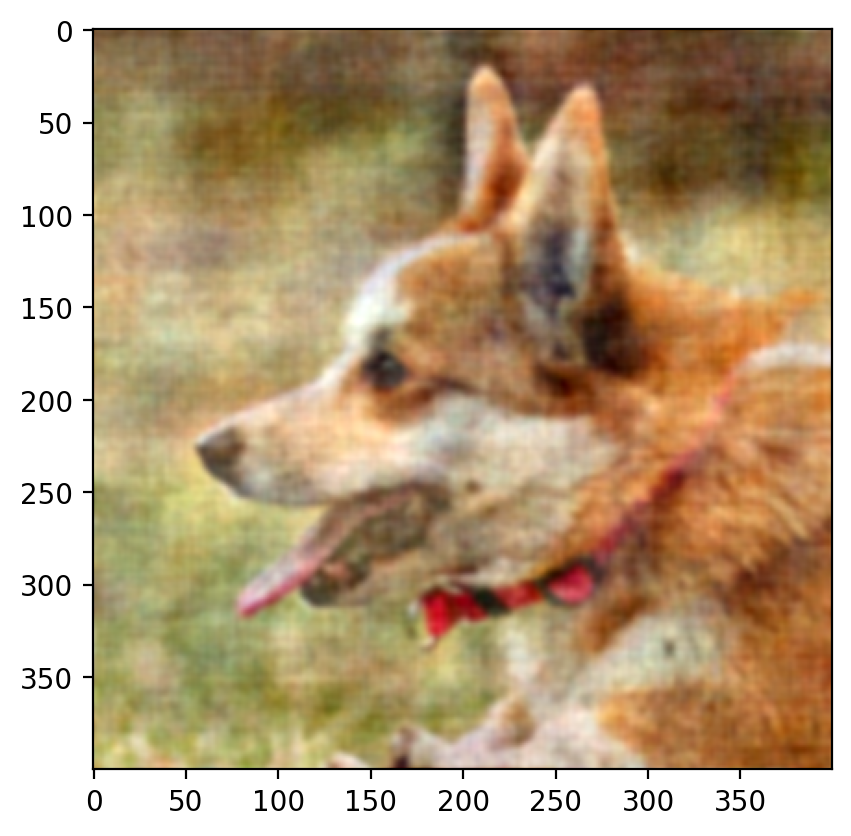

In [59]:
reconst_crop = reconstructedOutput(resized_crop,net,X1_rff)
crop_cpu = reconst_crop.cpu()
plt.imshow(crop_cpu.permute(0,1,2))
plt.show()


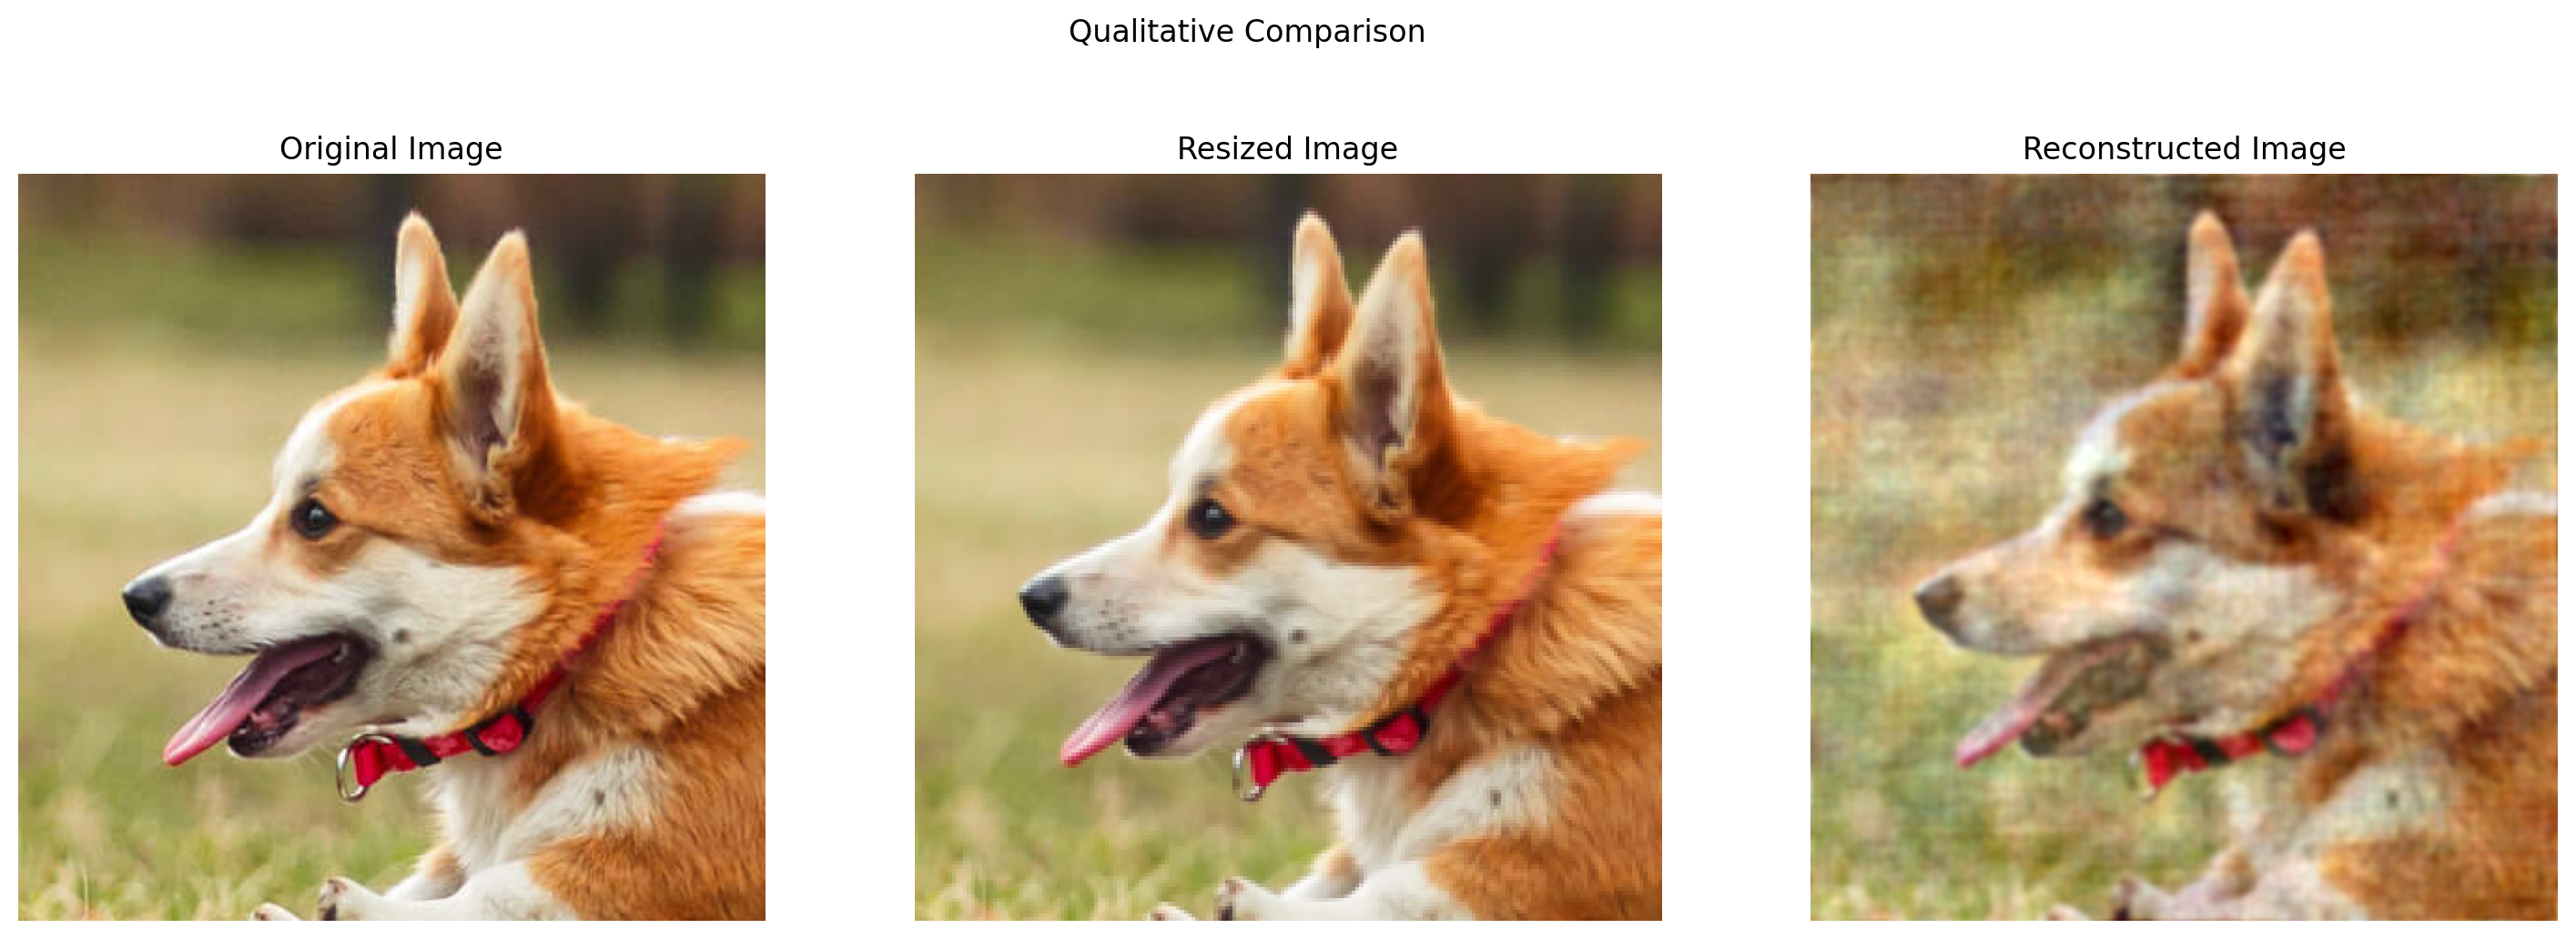

In [60]:
plot_images(reconst_crop.cpu(), resized_crop.cpu(), crop.cpu(), title="Qualitative Comparison")


In [61]:
def calculate_metrics(original, predicted):
    original = original.permute(1, 2, 0) 
    diff = original - predicted
    mse = torch.mean(diff ** 2)
    rmse = torch.sqrt(mse)
    max_pixel_value = 1.0
    psnr = 20 * torch.log10(max_pixel_value / rmse)
    
    print(f"RMSE: {rmse.item()}")
    print(f"PSNR: {psnr.item()} dB")
calculate_metrics(crop.cpu(), reconst_crop.cpu())

RMSE: 0.09073991025386695
PSNR: 20.844033092158174 dB
